# Homework 10
## Mengxiang Jiang

The majority of the code here comes from the [Companion Jupyter notebooks for the book "Deep Learning with Python"](https://github.com/fchollet/deep-learning-with-python-notebooks) by François Chollet, specifically chapter 10.
If the code comes from somewhere else it will have a source linked to the original.\
[Video Link](https://youtu.be/3stHd7w4hD0)

## Experiment 1: A temperature-forecasting example

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

/bin/bash: /home/mengxiang/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-04-11 16:58:58--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.164.221, 52.216.89.29, 52.217.14.62, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.164.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  1.70MB/s    in 7.4s    

2023-04-11 16:59:06 (1.76 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

/bin/bash: /home/mengxiang/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [2]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

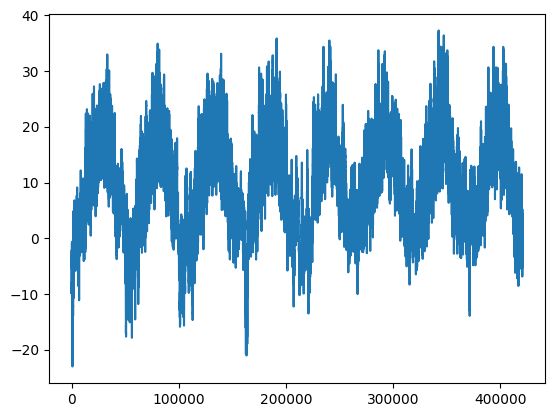

In [3]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

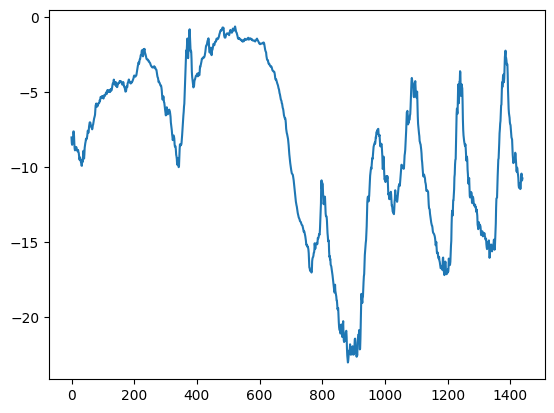

In [4]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data
**Normalizing the data**

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [7]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

2023-04-11 17:07:30.948468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 17:07:31.117258: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2023-04-11 17:07:32.532725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-11 17:07:32.541503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-11 17:07:32.541581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-11 17:07:32.542484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

**Instantiating datasets for training, validation, and testing**

In [8]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline
**Computing the common-sense baseline MAE**

In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a 1D convolutional model

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.Conv1D(8, 2, strides=2, activation="relu")(inputs)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.Conv1D(8, 2, strides=2, activation="relu")(inputs)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="jena_conv.keras",
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_mae",
        patience=5,
        restore_best_weights=True,
    )
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 4s 5ms/step - loss: 16.1995 - mae: 3.0604 - val_loss: 11.2265 - val_mae: 2.6418
Epoch 2/50
819/819 [==============================] - 4s 4ms/step - loss: 10.3817 - mae: 2.5248 - val_loss: 10.4887 - val_mae: 2.5615
Epoch 3/50
819/819 [==============================] - 4s 4ms/step - loss: 9.6792 - mae: 2.4377 - val_loss: 9.8764 - val_mae: 2.4801
Epoch 4/50
819/819 [==============================] - 4s 4ms/step - loss: 9.3532 - mae: 2.3942 - val_loss: 9.2312 - val_mae: 2.3864
Epoch 5/50
819/819 [==============================] - 4s 4ms/step - loss: 9.1349 - mae: 2.3640 - val_loss: 9.8924 - val_mae: 2.4773
Epoch 6/50
819/819 [==============================] - 4s 4ms/step - loss: 8.9941 - mae: 2.3452 - val_loss: 9.5711 - val_mae: 2.4352
Epoch 7/50
819/819 [==============================] - 4s 4ms/step - loss: 8.8751 - mae: 2.3302 - val_loss: 9.1288 - val_mae: 2.3678
Epoch 8/50
819/819 [==============================] - 4s 4ms/step - loss

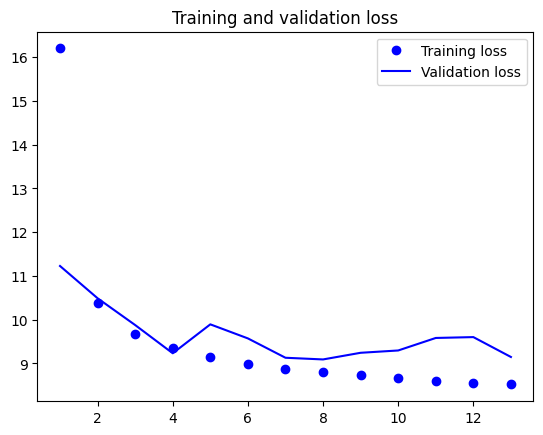

In [18]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

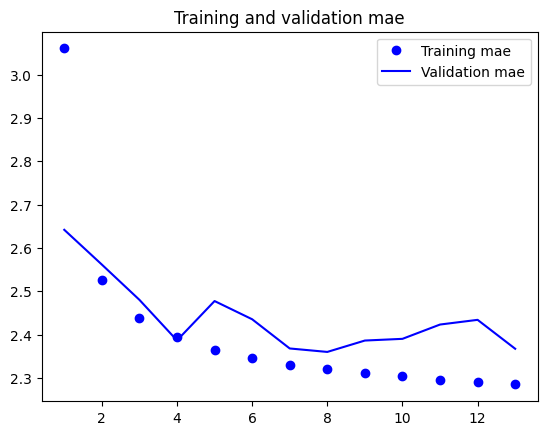

In [19]:
epochs = range(1, len(history.history["mae"]) + 1)
loss = history.history["mae"]
val_loss = history.history["val_mae"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training mae")
plt.plot(epochs, val_loss, "b", label="Validation mae")
plt.title("Training and validation mae")
plt.legend()

### Stacking recurrent layers
**Training and evaluating a dropout-regularized, stacked GRU model**

In [11]:
with tf.device("cpu"):
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
    x = layers.GRU(32, recurrent_dropout=0.5)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath="jena_stacked_gru_dropout.keras",
            save_best_only=True
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_mae",
            patience=5,
            restore_best_weights=True,
        )
    ]

    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(train_dataset,
                        epochs=50,
                        validation_data=val_dataset,
                        callbacks=callbacks)
    model = keras.models.load_model("jena_stacked_gru_dropout.keras")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
  3/819 [..............................] - ETA: 1:01 - loss: 151.7230 - mae: 10.2830

2023-04-10 14:48:30.041022: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fddf4033ce0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-10 14:48:30.041045: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-04-10 14:48:30.044404: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-10 14:48:30.070586: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


819/819 [==============================] - 69s 82ms/step - loss: 24.2315 - mae: 3.6413 - val_loss: 9.4858 - val_mae: 2.3800
Epoch 2/50
819/819 [==============================] - 67s 82ms/step - loss: 14.0389 - mae: 2.9008 - val_loss: 8.9331 - val_mae: 2.3111
Epoch 3/50
819/819 [==============================] - 67s 82ms/step - loss: 13.2625 - mae: 2.8196 - val_loss: 8.8944 - val_mae: 2.3132
Epoch 4/50
819/819 [==============================] - 67s 82ms/step - loss: 12.7564 - mae: 2.7666 - val_loss: 8.9021 - val_mae: 2.3199
Epoch 5/50
819/819 [==============================] - 67s 82ms/step - loss: 12.2996 - mae: 2.7160 - val_loss: 8.7069 - val_mae: 2.2773
Epoch 6/50
819/819 [==============================] - 67s 82ms/step - loss: 11.8114 - mae: 2.6658 - val_loss: 8.7220 - val_mae: 2.2823
Epoch 7/50
819/819 [==============================] - 68s 82ms/step - loss: 11.4415 - mae: 2.6231 - val_loss: 9.1999 - val_mae: 2.3508
Epoch 8/50
819/819 [==============================] - 68s 83ms/ste

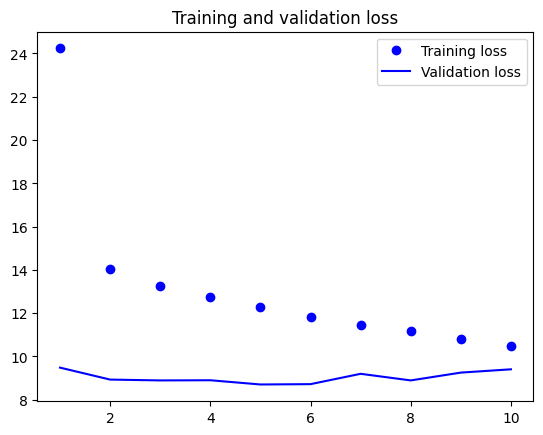

In [12]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

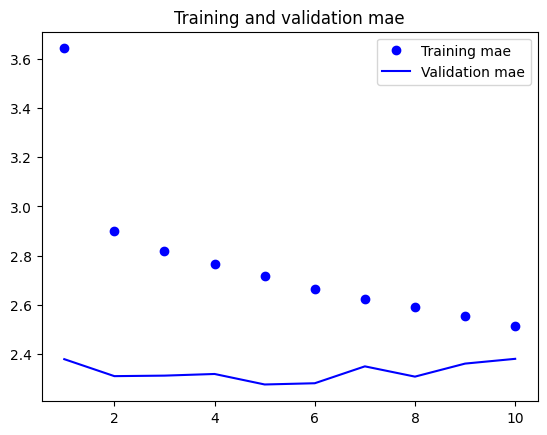

In [13]:
epochs = range(1, len(history.history["mae"]) + 1)
loss = history.history["mae"]
val_loss = history.history["val_mae"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training mae")
plt.plot(epochs, val_loss, "b", label="Validation mae")
plt.title("Training and validation mae")
plt.legend()

## Experiment 2: Adjusting the number of units and amount of dropout in each recurrent layer

**Varying the number of units**

In [15]:
def build_model(num_units):
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = layers.GRU(num_units, recurrent_dropout=0.5, return_sequences=True)(inputs)
    x = layers.GRU(num_units, recurrent_dropout=0.5)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model

num_units_list = [4, 8, 16, 32, 64]
histories = {}

with tf.device("cpu"):
    for num_units in num_units_list:
        model = build_model(num_units)
        fp = "jena_stacked_gru_dropout_num_units_" + str(num_units) + ".keras"
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=fp,
                save_best_only=True
            ),
            keras.callbacks.EarlyStopping(
                monitor="val_mae",
                patience=5,
                restore_best_weights=True,
            )
        ]
        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
        history = model.fit(train_dataset,
                            epochs=50,
                            validation_data=val_dataset,
                            callbacks=callbacks)
        print(f"Test MAE for {num_units} units: {model.evaluate(test_dataset)[1]:.2f}")
        histories[num_units] = history
    

Epoch 1/50
819/819 [==============================] - 42s 49ms/step - loss: 96.6448 - mae: 7.7406 - val_loss: 67.9228 - val_mae: 6.2891
Epoch 2/50
819/819 [==============================] - 40s 49ms/step - loss: 56.6867 - mae: 5.6311 - val_loss: 35.3760 - val_mae: 4.3584
Epoch 3/50
819/819 [==============================] - 40s 49ms/step - loss: 39.4571 - mae: 4.6429 - val_loss: 20.7184 - val_mae: 3.3815
Epoch 4/50
819/819 [==============================] - 40s 49ms/step - loss: 32.7714 - mae: 4.2436 - val_loss: 15.1781 - val_mae: 2.9550
Epoch 5/50
819/819 [==============================] - 41s 50ms/step - loss: 29.5829 - mae: 4.0511 - val_loss: 14.1452 - val_mae: 2.9031
Epoch 6/50
819/819 [==============================] - 41s 50ms/step - loss: 27.8846 - mae: 3.9446 - val_loss: 12.7772 - val_mae: 2.7558
Epoch 7/50
819/819 [==============================] - 41s 50ms/step - loss: 26.5576 - mae: 3.8593 - val_loss: 11.2028 - val_mae: 2.5805
Epoch 8/50
819/819 [============================

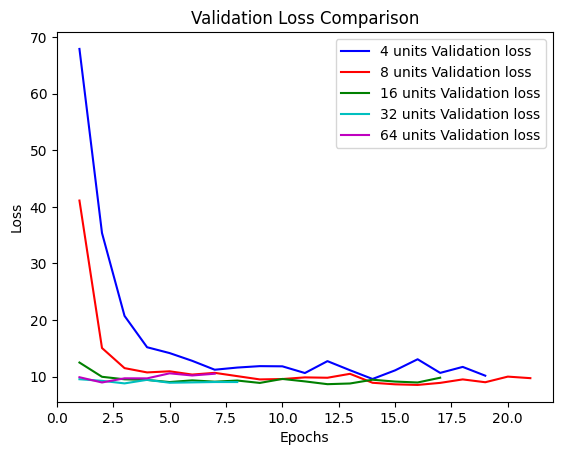

In [16]:
val_loss_4 = histories[4].history["val_loss"]
val_loss_8 = histories[8].history["val_loss"]
val_loss_16 = histories[16].history["val_loss"]
val_loss_32 = histories[32].history["val_loss"]
val_loss_64 = histories[64].history["val_loss"]
epochs_4 = range(1, len(val_loss_4)+1)
epochs_8 = range(1, len(val_loss_8)+1)
epochs_16 = range(1, len(val_loss_16)+1)
epochs_32 = range(1, len(val_loss_32)+1)
epochs_64 = range(1, len(val_loss_64)+1)
plt.plot(epochs_4, val_loss_4, "b-",
         label="4 units Validation loss")
plt.plot(epochs_8, val_loss_8, "r-",
         label="8 units Validation loss")
plt.plot(epochs_16, val_loss_16, "g-",
         label="16 units Validation loss")
plt.plot(epochs_32, val_loss_32, "c-",
         label="32 units Validation loss")
plt.plot(epochs_64, val_loss_64, "m-",
         label="64 units Validation loss")
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

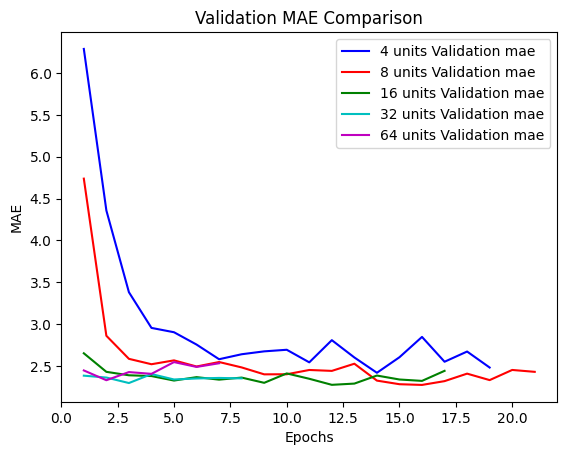

In [17]:
val_loss_4 = histories[4].history["val_mae"]
val_loss_8 = histories[8].history["val_mae"]
val_loss_16 = histories[16].history["val_mae"]
val_loss_32 = histories[32].history["val_mae"]
val_loss_64 = histories[64].history["val_mae"]
epochs_4 = range(1, len(val_loss_4)+1)
epochs_8 = range(1, len(val_loss_8)+1)
epochs_16 = range(1, len(val_loss_16)+1)
epochs_32 = range(1, len(val_loss_32)+1)
epochs_64 = range(1, len(val_loss_64)+1)
plt.plot(epochs_4, val_loss_4, "b-",
         label="4 units Validation mae")
plt.plot(epochs_8, val_loss_8, "r-",
         label="8 units Validation mae")
plt.plot(epochs_16, val_loss_16, "g-",
         label="16 units Validation mae")
plt.plot(epochs_32, val_loss_32, "c-",
         label="32 units Validation mae")
plt.plot(epochs_64, val_loss_64, "m-",
         label="64 units Validation mae")
plt.title("Validation MAE Comparison")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

In [18]:

model = keras.models.load_model("jena_stacked_gru_dropout_num_units_4.keras")
print(f"Test MAE for 4 units: {model.evaluate(test_dataset)[1]:.2f}")
model = keras.models.load_model("jena_stacked_gru_dropout_num_units_8.keras")
print(f"Test MAE for 8 units: {model.evaluate(test_dataset)[1]:.2f}")
model = keras.models.load_model("jena_stacked_gru_dropout_num_units_16.keras")
print(f"Test MAE for 16 units: {model.evaluate(test_dataset)[1]:.2f}")
model = keras.models.load_model("jena_stacked_gru_dropout_num_units_32.keras")
print(f"Test MAE for 32 units: {model.evaluate(test_dataset)[1]:.2f}")
model = keras.models.load_model("jena_stacked_gru_dropout_num_units_64.keras")
print(f"Test MAE for 64 units: {model.evaluate(test_dataset)[1]:.2f}")

  3/405 [..............................] - ETA: 10s - loss: 10.4514 - mae: 2.5631

2023-04-10 17:06:10.726519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


405/405 [==============================] - 12s 26ms/step - loss: 10.8994 - mae: 2.5717
Test MAE for 4 units: 2.57
405/405 [==============================] - 11s 26ms/step - loss: 9.8987 - mae: 2.4634
Test MAE for 8 units: 2.46
405/405 [==============================] - 10s 24ms/step - loss: 9.8301 - mae: 2.4496
Test MAE for 16 units: 2.45
405/405 [==============================] - 10s 24ms/step - loss: 9.8332 - mae: 2.4483
Test MAE for 32 units: 2.45
405/405 [==============================] - 10s 24ms/step - loss: 10.0200 - mae: 2.5043
Test MAE for 64 units: 2.50


**Varying the rate of drop out**

In [20]:
def build_model(drop_out_rate):
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = layers.GRU(32, recurrent_dropout=drop_out_rate, return_sequences=True)(inputs)
    x = layers.GRU(32, recurrent_dropout=drop_out_rate)(x)
    x = layers.Dropout(drop_out_rate)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model

drop_out_rate_list = [0.2, 0.3, 0.4, 0.5, 0.6]

with tf.device("cpu"):
    for drop_out_rate in drop_out_rate_list:
        model = build_model(drop_out_rate)
        fp = "jena_stacked_gru_dropout_rate_" + str(drop_out_rate) + ".keras"
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=fp,
                save_best_only=True
            ),
            keras.callbacks.EarlyStopping(
                monitor="val_mae",
                patience=5,
                restore_best_weights=True,
            )
        ]
        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
        history = model.fit(train_dataset,
                            epochs=50,
                            validation_data=val_dataset,
                            callbacks=callbacks)
        print(f"Test MAE for {drop_out_rate} dropout: {model.evaluate(test_dataset)[1]:.2f}")
        histories[drop_out_rate] = history

Epoch 1/50
819/819 [==============================] - 70s 84ms/step - loss: 22.8214 - mae: 3.4633 - val_loss: 9.1089 - val_mae: 2.3378
Epoch 2/50
819/819 [==============================] - 69s 85ms/step - loss: 10.5573 - mae: 2.5389 - val_loss: 10.7598 - val_mae: 2.5779
Epoch 3/50
819/819 [==============================] - 69s 84ms/step - loss: 9.7855 - mae: 2.4447 - val_loss: 8.6878 - val_mae: 2.2825
Epoch 4/50
819/819 [==============================] - 70s 85ms/step - loss: 9.1859 - mae: 2.3705 - val_loss: 9.2513 - val_mae: 2.3714
Epoch 5/50
819/819 [==============================] - 70s 85ms/step - loss: 8.6412 - mae: 2.3017 - val_loss: 9.6781 - val_mae: 2.4237
Epoch 6/50
819/819 [==============================] - 70s 85ms/step - loss: 8.1821 - mae: 2.2391 - val_loss: 9.9937 - val_mae: 2.4582
Epoch 7/50
819/819 [==============================] - 70s 86ms/step - loss: 7.7212 - mae: 2.1755 - val_loss: 10.1220 - val_mae: 2.4706
Epoch 8/50
405/405 [==============================] - 8s 1

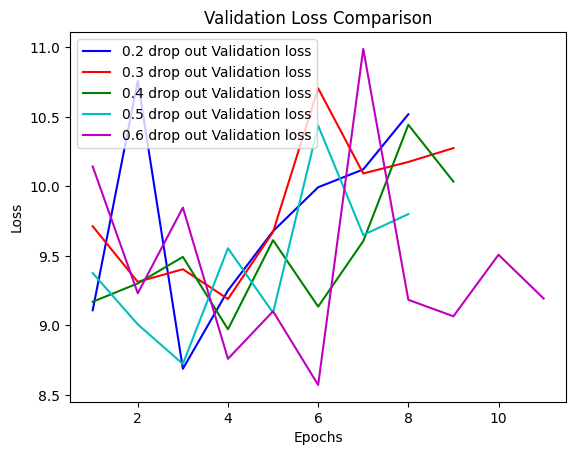

In [21]:
val_loss_4 = histories[0.2].history["val_loss"]
val_loss_8 = histories[0.3].history["val_loss"]
val_loss_16 = histories[0.4].history["val_loss"]
val_loss_32 = histories[0.5].history["val_loss"]
val_loss_64 = histories[0.6].history["val_loss"]
epochs_4 = range(1, len(val_loss_4)+1)
epochs_8 = range(1, len(val_loss_8)+1)
epochs_16 = range(1, len(val_loss_16)+1)
epochs_32 = range(1, len(val_loss_32)+1)
epochs_64 = range(1, len(val_loss_64)+1)
plt.plot(epochs_4, val_loss_4, "b-",
         label="0.2 drop out Validation loss")
plt.plot(epochs_8, val_loss_8, "r-",
         label="0.3 drop out Validation loss")
plt.plot(epochs_16, val_loss_16, "g-",
         label="0.4 drop out Validation loss")
plt.plot(epochs_32, val_loss_32, "c-",
         label="0.5 drop out Validation loss")
plt.plot(epochs_64, val_loss_64, "m-",
         label="0.6 drop out Validation loss")
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

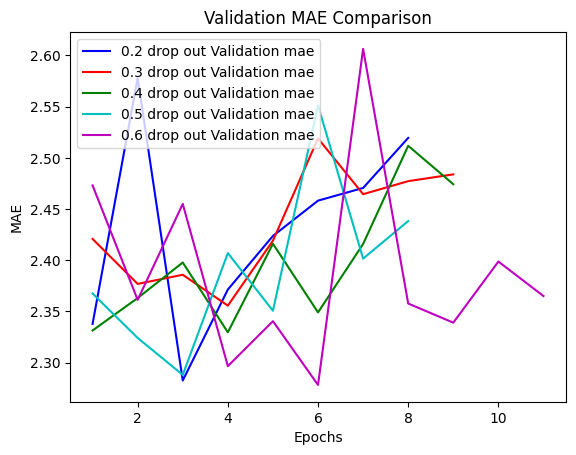

In [24]:
val_loss_4 = histories[0.2].history["val_mae"]
val_loss_8 = histories[0.3].history["val_mae"]
val_loss_16 = histories[0.4].history["val_mae"]
val_loss_32 = histories[0.5].history["val_mae"]
val_loss_64 = histories[0.6].history["val_mae"]
epochs_4 = range(1, len(val_loss_4)+1)
epochs_8 = range(1, len(val_loss_8)+1)
epochs_16 = range(1, len(val_loss_16)+1)
epochs_32 = range(1, len(val_loss_32)+1)
epochs_64 = range(1, len(val_loss_64)+1)
plt.plot(epochs_4, val_loss_4, "b-",
         label="0.2 drop out Validation mae")
plt.plot(epochs_8, val_loss_8, "r-",
         label="0.3 drop out Validation mae")
plt.plot(epochs_16, val_loss_16, "g-",
         label="0.4 drop out Validation mae")
plt.plot(epochs_32, val_loss_32, "c-",
         label="0.5 drop out Validation mae")
plt.plot(epochs_64, val_loss_64, "m-",
         label="0.6 drop out Validation mae")
plt.title("Validation MAE Comparison")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

In [25]:
model = keras.models.load_model("jena_stacked_gru_dropout_rate_0.2.keras")
print(f"Test MAE for 0.2 drop out: {model.evaluate(test_dataset)[1]:.2f}")
model = keras.models.load_model("jena_stacked_gru_dropout_rate_0.3.keras")
print(f"Test MAE for 0.3 drop out: {model.evaluate(test_dataset)[1]:.2f}")
model = keras.models.load_model("jena_stacked_gru_dropout_rate_0.4.keras")
print(f"Test MAE for 0.4 drop out: {model.evaluate(test_dataset)[1]:.2f}")
model = keras.models.load_model("jena_stacked_gru_dropout_rate_0.5.keras")
print(f"Test MAE for 0.5 drop out: {model.evaluate(test_dataset)[1]:.2f}")
model = keras.models.load_model("jena_stacked_gru_dropout_rate_0.6.keras")
print(f"Test MAE for 0.6 drop out: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 10s 24ms/step - loss: 9.5733 - mae: 2.4334
Test MAE for 0.2 drop out: 2.43
405/405 [==============================] - 10s 24ms/step - loss: 9.5393 - mae: 2.4190
Test MAE for 0.3 drop out: 2.42
405/405 [==============================] - 10s 24ms/step - loss: 10.0423 - mae: 2.4799
Test MAE for 0.4 drop out: 2.48
405/405 [==============================] - 10s 24ms/step - loss: 9.6031 - mae: 2.4273
Test MAE for 0.5 drop out: 2.43
405/405 [==============================] - 10s 24ms/step - loss: 9.8520 - mae: 2.4570
Test MAE for 0.6 drop out: 2.46


## Experiment 3: Adjust learning rate and try a different optimizer

**Adjusting learning rate**

In [27]:
def build_model():
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
    x = layers.GRU(32, recurrent_dropout=0.5)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model

learning_rate_list = [0.1, 0.01, 0.001, 0.0001]

with tf.device("cpu"):
    for learning_rate in learning_rate_list:
        model = build_model()
        fp = "jena_stacked_gru_dropout_lr_" + str(learning_rate) + ".keras"
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=fp,
                save_best_only=True
            ),
            keras.callbacks.EarlyStopping(
                monitor="val_mae",
                patience=5,
                restore_best_weights=True,
            )
        ]
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
        model.compile(optimizer=opt, loss="mse", metrics=["mae"])
        history = model.fit(train_dataset,
                            epochs=50,
                            validation_data=val_dataset,
                            callbacks=callbacks)
        print(f"Test MAE for {learning_rate} learning rate: {model.evaluate(test_dataset)[1]:.2f}")
        histories[learning_rate] = history

Epoch 1/50
819/819 [==============================] - 71s 85ms/step - loss: 33.3586 - mae: 4.5215 - val_loss: 28.8811 - val_mae: 4.2016
Epoch 2/50
819/819 [==============================] - 70s 85ms/step - loss: 34.6248 - mae: 4.6245 - val_loss: 21.3194 - val_mae: 3.6093
Epoch 3/50
819/819 [==============================] - 69s 85ms/step - loss: 31.8125 - mae: 4.4327 - val_loss: 21.0762 - val_mae: 3.6688
Epoch 4/50
819/819 [==============================] - 69s 85ms/step - loss: 31.4183 - mae: 4.4029 - val_loss: 21.5695 - val_mae: 3.6403
Epoch 5/50
819/819 [==============================] - 70s 86ms/step - loss: 32.4476 - mae: 4.4730 - val_loss: 25.0125 - val_mae: 3.8524
Epoch 6/50
819/819 [==============================] - 70s 86ms/step - loss: 33.7387 - mae: 4.5507 - val_loss: 29.7461 - val_mae: 4.2476
Epoch 7/50
405/405 [==============================] - 8s 19ms/step - loss: 23.9908 - mae: 3.8201
Test MAE for 0.1 learning rate: 3.82
Epoch 1/50
819/819 [==============================

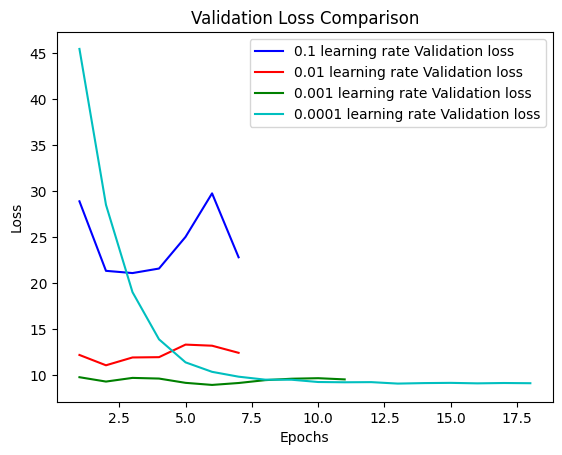

In [28]:
val_loss_4 = histories[0.1].history["val_loss"]
val_loss_8 = histories[0.01].history["val_loss"]
val_loss_16 = histories[0.001].history["val_loss"]
val_loss_32 = histories[0.0001].history["val_loss"]
epochs_4 = range(1, len(val_loss_4)+1)
epochs_8 = range(1, len(val_loss_8)+1)
epochs_16 = range(1, len(val_loss_16)+1)
epochs_32 = range(1, len(val_loss_32)+1)
plt.plot(epochs_4, val_loss_4, "b-",
         label="0.1 learning rate Validation loss")
plt.plot(epochs_8, val_loss_8, "r-",
         label="0.01 learning rate Validation loss")
plt.plot(epochs_16, val_loss_16, "g-",
         label="0.001 learning rate Validation loss")
plt.plot(epochs_32, val_loss_32, "c-",
         label="0.0001 learning rate Validation loss")
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

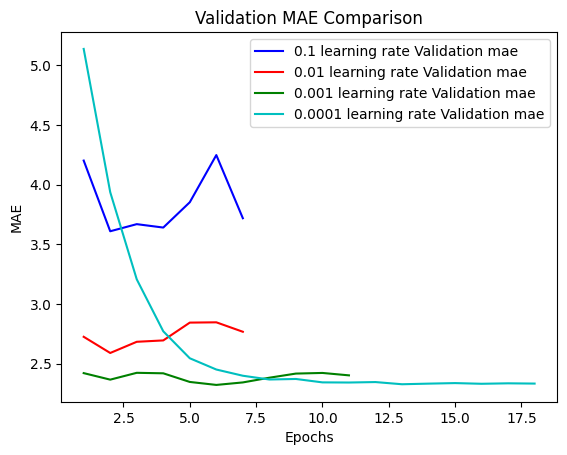

In [29]:
val_loss_4 = histories[0.1].history["val_mae"]
val_loss_8 = histories[0.01].history["val_mae"]
val_loss_16 = histories[0.001].history["val_mae"]
val_loss_32 = histories[0.0001].history["val_mae"]
epochs_4 = range(1, len(val_loss_4)+1)
epochs_8 = range(1, len(val_loss_8)+1)
epochs_16 = range(1, len(val_loss_16)+1)
epochs_32 = range(1, len(val_loss_32)+1)
plt.plot(epochs_4, val_loss_4, "b-",
         label="0.1 learning rate Validation mae")
plt.plot(epochs_8, val_loss_8, "r-",
         label="0.01 learning rate Validation mae")
plt.plot(epochs_16, val_loss_16, "g-",
         label="0.001 learning rate Validation mae")
plt.plot(epochs_32, val_loss_32, "c-",
         label="0.0001 learning rate Validation mae")
plt.title("Validation MAE Comparison")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

In [37]:
model = keras.models.load_model("jena_stacked_gru_dropout_lr_0.1.keras")
print(f"Test MAE for 0.1 learning rate: {model.evaluate(test_dataset)[1]:.2f}")
model = keras.models.load_model("jena_stacked_gru_dropout_lr_0.01.keras")
print(f"Test MAE for 0.01 learning rate: {model.evaluate(test_dataset)[1]:.2f}")
model = keras.models.load_model("jena_stacked_gru_dropout_lr_0.001.keras")
print(f"Test MAE for 0.001 learning rate: {model.evaluate(test_dataset)[1]:.2f}")
model = keras.models.load_model("jena_stacked_gru_dropout_lr_0.0001.keras")
print(f"Test MAE for 0.0001 learning rate: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 10s 24ms/step - loss: 22.0690 - mae: 3.7082
Test MAE for 0.1 learning rate: 3.71
405/405 [==============================] - 10s 24ms/step - loss: 12.3006 - mae: 2.7503
Test MAE for 0.01 learning rate: 2.75
405/405 [==============================] - 10s 24ms/step - loss: 9.6234 - mae: 2.4323
Test MAE for 0.001 learning rate: 2.43
405/405 [==============================] - 10s 24ms/step - loss: 10.4565 - mae: 2.5152
Test MAE for 0.0001 learning rate: 2.52


**Change to the Adafactor optimzer**

In [30]:
with tf.device("cpu"):
    model = build_model()
    fp = "jena_stacked_gru_dropout_adafactor.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=fp,
            save_best_only=True
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_mae",
            patience=5,
            restore_best_weights=True,
        )
    ]
    opt = keras.optimizers.experimental.Adafactor()
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])
    history = model.fit(train_dataset,
                        epochs=50,
                        validation_data=val_dataset,
                        callbacks=callbacks)
    print(f"Test MAE for the Adafactor optimzer: {model.evaluate(test_dataset)[1]:.2f}")
    histories["adafactor"] = history

Epoch 1/50
819/819 [==============================] - 71s 85ms/step - loss: 92.7866 - mae: 7.8177 - val_loss: 29.0826 - val_mae: 4.1139
Epoch 2/50
819/819 [==============================] - 69s 85ms/step - loss: 24.5976 - mae: 3.8101 - val_loss: 13.1446 - val_mae: 2.7663
Epoch 3/50
819/819 [==============================] - 69s 84ms/step - loss: 17.9355 - mae: 3.2955 - val_loss: 10.1690 - val_mae: 2.4584
Epoch 4/50
819/819 [==============================] - 70s 85ms/step - loss: 16.4802 - mae: 3.1611 - val_loss: 9.5786 - val_mae: 2.3935
Epoch 5/50
819/819 [==============================] - 70s 85ms/step - loss: 15.8427 - mae: 3.0990 - val_loss: 9.4027 - val_mae: 2.3703
Epoch 6/50
819/819 [==============================] - 70s 85ms/step - loss: 15.3783 - mae: 3.0531 - val_loss: 9.3201 - val_mae: 2.3644
Epoch 7/50
819/819 [==============================] - 69s 84ms/step - loss: 15.0778 - mae: 3.0169 - val_loss: 9.1817 - val_mae: 2.3422
Epoch 8/50
819/819 [==============================] 

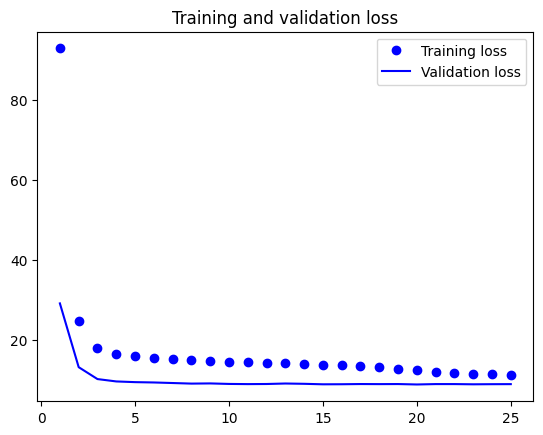

In [31]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

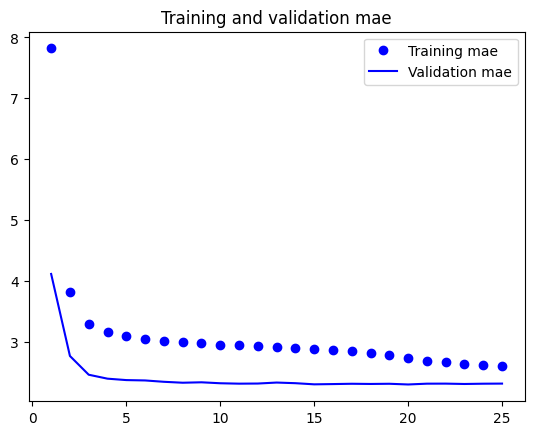

In [32]:
epochs = range(1, len(history.history["mae"]) + 1)
loss = history.history["mae"]
val_loss = history.history["val_mae"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training mae")
plt.plot(epochs, val_loss, "b", label="Validation mae")
plt.title("Training and validation mae")
plt.legend()

## Experiment 4: Add dense layers

In [34]:
def build_model():
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
    x = layers.GRU(32, recurrent_dropout=0.5)(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model

with tf.device("cpu"):
    model = build_model()
    fp = "jena_stacked_gru_dropout_added_dense.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=fp,
            save_best_only=True
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_mae",
            patience=5,
            restore_best_weights=True,
        )
    ]
    model.compile(optimizer='rmsprop', loss="mse", metrics=["mae"])
    history = model.fit(train_dataset,
                        epochs=50,
                        validation_data=val_dataset,
                        callbacks=callbacks)
    print(f"Test MAE for added dense layers: {model.evaluate(test_dataset)[1]:.2f}")
    histories["dense"] = history


Epoch 1/50
819/819 [==============================] - 71s 84ms/step - loss: 52.9974 - mae: 5.3958 - val_loss: 15.5786 - val_mae: 3.0954
Epoch 2/50
819/819 [==============================] - 69s 84ms/step - loss: 41.2470 - mae: 4.7250 - val_loss: 13.9456 - val_mae: 2.9504
Epoch 3/50
819/819 [==============================] - 69s 84ms/step - loss: 38.1438 - mae: 4.5290 - val_loss: 13.1957 - val_mae: 2.8555
Epoch 4/50
819/819 [==============================] - 69s 84ms/step - loss: 35.2344 - mae: 4.3584 - val_loss: 12.5567 - val_mae: 2.7940
Epoch 5/50
819/819 [==============================] - 69s 85ms/step - loss: 32.8284 - mae: 4.2120 - val_loss: 13.3991 - val_mae: 2.9008
Epoch 6/50
819/819 [==============================] - 69s 85ms/step - loss: 30.4961 - mae: 4.0622 - val_loss: 15.2445 - val_mae: 3.0986
Epoch 7/50
819/819 [==============================] - 69s 84ms/step - loss: 28.8842 - mae: 3.9540 - val_loss: 11.8942 - val_mae: 2.7200
Epoch 8/50
819/819 [============================

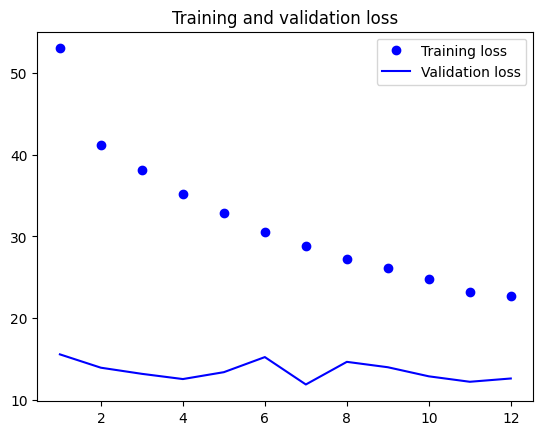

In [35]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

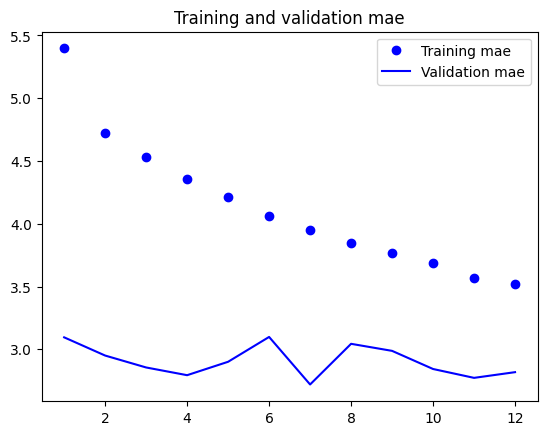

In [36]:
epochs = range(1, len(history.history["mae"]) + 1)
loss = history.history["mae"]
val_loss = history.history["val_mae"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training mae")
plt.plot(epochs, val_loss, "b", label="Validation mae")
plt.title("Training and validation mae")
plt.legend()